# YOLO With Caution: Using Epsilon Constraints for Unbiased Pedestrian Detection
By Kaylee Scanlin, July 29th 2024

A pertinent question in computer vision and autonomous vehicles is how to detect pedestrians in low-lighting conditions. This is especially important when discussing how to account for bias in Autonomous Vehicle detection algorithms. A review published by telefonica research in 2024 highlights how the underrepresentation in commonly-used computer vision datasets such as KAIST, nuScenes, and Waymo of certain demographic groups- as well as different kinds of pedestrians, such as bikers and children- can lead to bias during detection: https://arxiv.org/pdf/2401.10397

The YOLO detection algorithm has been proposed as a potential solution, but even it has its own faults. Due to its grid-based visual detection system, it has difficulty identifying pedestrians from far away. Furthermore, YOLO detection- while considered more efficient than RNN and faster RNN- is still computationally expensive, even in its lite form: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8621865

An algorithmic solution is proposed in this paper to the specific problem of the difficulty in identifying pedestrians of color in low lighting. First, a convolutional neural network is created and trained on the KAIST dataset with the YOLO detection algorithm, and measured for recall (TP / TP + FN), since the false negative rate is perhaps the most important metric in pedestrian detection. Secondly, a separate convolutional neural network is created using an ε-constraint in the form of the sensitivity of the bounding boxes to demonstrate the algorithm corrected for its biases. The time complexity for both algorithms is measured in Big-O notation to keep track of their efficiency.

## How YOLO Works
Object detection is a crucial component of computer vision, with applications ranging from autonomous vehicles to surveillance systems. The YOLO (You Only Look Once) algorithm has gained prominence in recent years for its efficiency and accuracy in detecting objects in real-time.

YOLO's (You Only Look Once) architecture is based on a single convolutional neural network (CNN) that predicts multiple bounding boxes and class probabilities for those boxes simultaneously. The network divides the image into an SxS grid, and each grid cell predicts B bounding boxes, confidence scores, and class probabilities for any objects they detect in frame- as opposed to traditional methods of computer vision, which calculate multiple iterations of these for each of the prior.

YOLO gets its name from the single forward pass it makes through the neural network, unlike Haar Cascades, R-CNN, and faster R-CNN, which all require multiple passes.

## RCNN
![RCNNdiagram](https://i.imgur.com/tWYbIn7.png)
Region-based CNNs, another SOTA image detection method, requires more than one trainable model. First it proposes a region detection model. Each detected region is scanned for features by a Convolutional Neural Network (CNN), which are extracted into feature vectors, as well as a support vector machine for each class. These three models are typically trained separately, making them slower and more computationally expensive than YOLO models.

## YOLO
![YOLOdiagram](https://i.imgur.com/0KM6ZqC.png)
The distinguishing feature of YOLO is that instead of looking at images multiple times, it divides a single image into multiple grids, from which feature vectors are extracted from each grid indidually. A bounding box for the object, as well as a confidence score, is extracted from each box; as well as a class probabiity region. This information is then combined to yield object detection.


# Epsilon(ε) Constraints
In machine learning, an epsilon constraint is a method used to enforce some level of fairness among different groups by setting a limit, denoted as epsilon, on the disparity of a particular metric between these groups. For instance, when designing a model to predict loan approvals, you could use an epsilon constraint to ensure that the approval rate for minority groups is not less than an epsilon difference from the majority group's approval rate. This method tries to control discrimination by making sure the outcomes (like approval rates) do not differ by more than the predefined epsilon value between different demographic groups. Epsilon constraints are a way to introduce a mathematical and quantitative approach to fairness, aiming to reduce bias in algorithmic decisions by maintaining the disparity within acceptable bounds. This helps in promoting equity and preventing significant biases in automated decisions across different groups.

In this project, the epsilon constraints used were placed on the contrast of the original test images. By increasing the contrast between the pedestrian and the surrounding background up to a certain threshold, we make it easier for the CNN to detect features from their backgrounds in the images.

**The full paper by Curtis, Liu, and Robinson can be found here**: https://utexas.box.com/s/dyg0nma0164c30b0mgzvqhh1lci1sk7c

# We begin by developing a YOLO algorithm without an ε-constraint to demonstrate how it functions:

In [ ]:
# !pip install tensorflow keras

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


**Mounting google drive:**
We uploaded our datasets to a google drive to work with google colab, so we connect it here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Defining our Yolo Algorithm**
Here we define a CNN with Keras to conduct the functions of the YOLO algorithm.
*If you look at the original layers of the YOLO v1 paper, you'll find they match.

In [ ]:
def yolo_v1(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Layer 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = Conv2D(192, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3 - 4
    for filters in [128, 256, 256, 512]:
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        if filters == 512:
            x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 5 - 6
    for _ in range(4):
        x = Conv2D(512, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 7 - 8
    for _ in range(2):
        x = Conv2D(1024, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(1024, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(1024, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Flatten()(x)

    x = Dense(4096)(x)
    x = LeakyReLU(alpha=0.1)(x)

    output_layer = Dense(7 * 7 * (num_classes + 5))(x)
    output_layer = Reshape((7, 7, num_classes + 5))(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

input_shape = (448, 448, 3)
num_classes = 1  # Only one class: pedestrian

model = yolo_v1(input_shape, num_classes)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 448, 448, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 192)       │         110,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 192)       │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 192)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 512)         │       1,180,1

 Total params: 261,082,470 (995.95 MB)

 Trainable params: 261,065,318 (995.89 MB)

 Non-trainable params: 17,152 (67.00 KB)

# Displaying biased training data


In [ ]:
# This does nothing aside from display the orignal images. This is not our model!

def load_dataset(image_dir, annotation_file, input_shape, num_classes):
    with open(annotation_file, 'r') as f:
        lines = f.readlines()

    num_samples = len(lines)
    X = np.zeros((num_samples, *input_shape))
    y = np.zeros((num_samples, 7, 7, num_classes + 5))

    for i, line in enumerate(lines):
        parts = line.strip().split()
        img_path = os.path.join(image_dir, parts[0])
        image = cv2.imread(img_path)
        image = cv2.resize(image, (input_shape[1], input_shape[0]))
        X[i] = image / 255.0  # Normalize image

        x_min = float(parts[1])
        y_min = float(parts[2])
        x_max = float(parts[3])
        y_max = float(parts[4])
        class_id = int(parts[5])

        # Convert to relative coordinates
        box_center_x = (x_min + x_max) / 2 / input_shape[1]
        box_center_y = (y_min + y_max) / 2 / input_shape[0]
        box_width = (x_max - x_min) / input_shape[1]
        box_height = (y_max - y_min) / input_shape[0]

        # Ensure cell indices are within bounds
        cell_x = int(min(box_center_x * 7, 6))  # Cap at 6
        cell_y = int(min(box_center_y * 7, 6))  # Cap at 6

        y[i, cell_y, cell_x, 0:4] = [box_center_x, box_center_y, box_width, box_height]
        y[i, cell_y, cell_x, 4] = 1  # Confidence
        y[i, cell_y, cell_x, 5 + class_id] = 1  # Class

    return X, y

image_dir = '/content/drive/MyDrive/My_pedestrian_dataset/train'
annotation_file = '/content/drive/MyDrive/My_pedestrian_dataset/train_annotations/_annotations.txt'

X_train, y_train = load_dataset(image_dir, annotation_file, input_shape, num_classes)


In [ ]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 58s 824ms/step - loss: 180.8089 - val_loss: 20054214656.0000
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - loss: 2.4199 - val_loss: 6172982784.0000
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - loss: 1.3774 - val_loss: 112158896.0000
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - loss: 0.5578 - val_loss: 8080749.5000
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - loss: 0.4233 - val_loss: 1121459.8750
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - loss: 0.1804 - val_loss: 109924.6797
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - loss: 0.1119 - val_loss: 16007.9033
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - loss: 0.0855 - val_loss: 2094.8333
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - loss: 0.0905 - val_loss: 361.4887
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - loss: 0.1229 - val_loss: 19.6651
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - loss: 0.0928 - v

# Plotting the loss function of this biased training data:
Because we're training our model on the biased training data, which already has the bounding box data, the loss function should be straightforward and linear.

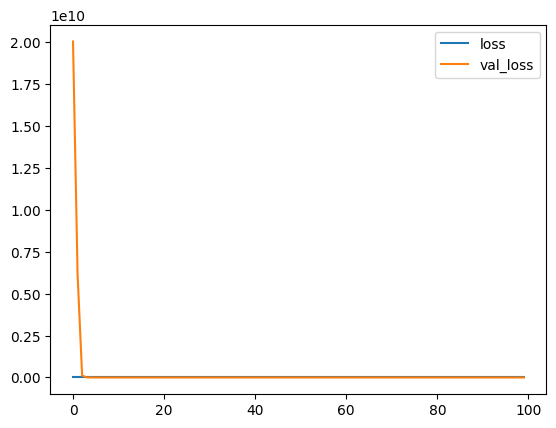

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


# Displaying our count of the images with bounding boxes versus without bounding boxes:
Should be 100% images with bounding boxes, as this is a biased dataset.

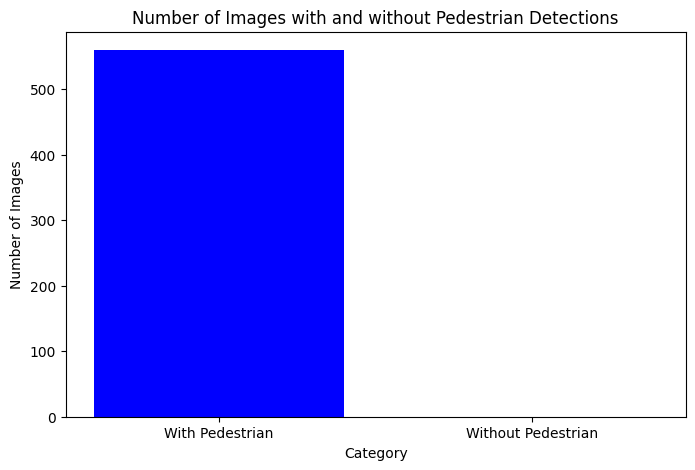

In [ ]:
import matplotlib.pyplot as plt

def plot_pedestrian_detections(y_data, num_classes):
    with_pedestrian = 0
    without_pedestrian = 0

    # Iterate through all annotations
    for y_sample in y_data:
        if np.sum(y_sample[..., num_classes + 4]) > 0:  # Check for any confidence value greater than 0
            with_pedestrian += 1
        else:
            without_pedestrian += 1

    # Bar graph plotting
    labels = ['With Pedestrian', 'Without Pedestrian']
    counts = [with_pedestrian, without_pedestrian]
    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color=['blue', 'red'])
    plt.title('Number of Images with and without Pedestrian Detections')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.show()

# Call this function after loading your dataset
plot_pedestrian_detections(y_train, num_classes)


# Displaying 5 random images from the training data:

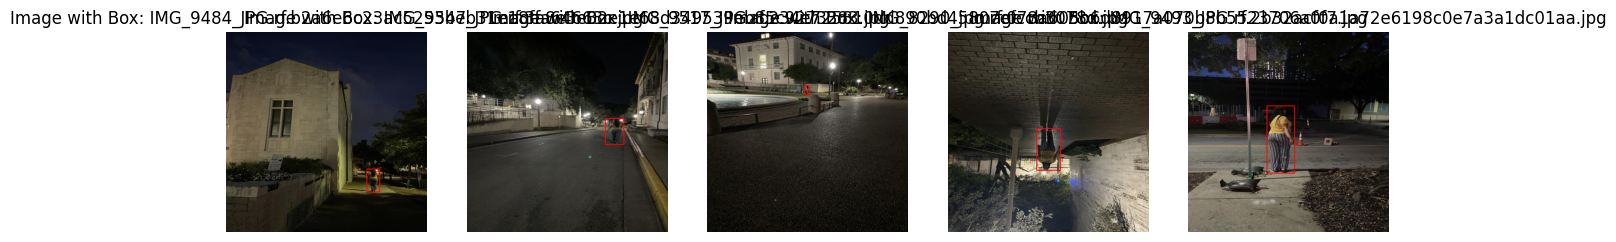

In [ ]:
import random

def display_random_images_with_boxes(image_dir, annotation_file, num_images=5):
    # Load annotations
    with open(annotation_file, 'r') as f:
        lines = f.readlines()

    # Randomly select images
    selected_lines = random.sample(lines, num_images)

    plt.figure(figsize=(15, 10))

    for idx, line in enumerate(selected_lines):
        parts = line.strip().split()
        img_path = os.path.join(image_dir, parts[0])
        image = cv2.imread(img_path)

        if image is None:
            print(f"Image not found at {img_path}")
            continue

        # Convert image from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract bounding box coordinates
        x_min = int(parts[1])
        y_min = int(parts[2])
        x_max = int(parts[3])
        y_max = int(parts[4])

        # Draw bounding box on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        # Display the image
        ax = plt.subplot(1, num_images, idx + 1)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Image with Box: {parts[0]}")

    plt.show()

# Call the function to display the images
display_random_images_with_boxes(image_dir, annotation_file)


# Displaying 5 random images from the testing dataset with model's predictions of bounding boxes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


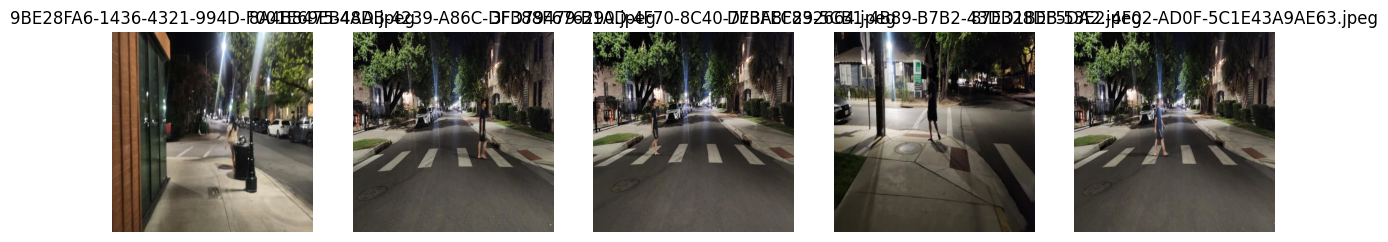

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

def load_images_from_folder(folder, target_size=(448, 448)):
    image_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    images = []
    file_names = []
    for img_name in image_files:
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img / 255.0)  # Normalize to 0-1
            file_names.append(img_name)
    return np.array(images), file_names

def predict_and_display(model, images, file_names, num_display=5, conf_threshold=0.5):
    predictions = model.predict(images)

    # Select random images to display
    indices = random.sample(range(len(images)), num_display)

    plt.figure(figsize=(15, 10))
    for idx, i in enumerate(indices):
        img = images[i]
        pred = predictions[i]
        grid_size = 448 / 7

        # Iterate over each cell in the grid
        for cy in range(7):
            for cx in range(7):
                vector = pred[cy, cx]
                confidence = vector[4]

                # Apply confidence threshold to filter predictions
                if confidence > conf_threshold:
                    bx, by, bw, bh = vector[:4]

                    # Convert predictions to pixel values for the actual image size
                    x_center = int((cx + bx) * grid_size)
                    y_center = int((cy + by) * grid_size)
                    width = int(bw * 448)
                    height = int(bh * 448)
                    x_min = int(x_center - width / 2)
                    y_min = int(y_center - height / 2)
                    x_max = int(x_center + width / 2)
                    y_max = int(y_center + height / 2)

                    # Draw bounding box on the image
                    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        # Display the image
        ax = plt.subplot(1, num_display, idx + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(file_names[i])

    plt.show()

# Specify the folder path
test_image_dir = '/content/drive/MyDrive/My_pedestrian_dataset/test'

# Load and preprocess the images
test_images, test_file_names = load_images_from_folder(test_image_dir)

# Make predictions and display the results
predict_and_display(model, test_images, test_file_names)




# Loss function without epsilon constraint compared to true annotation values:


In [ ]:
def compute_loss(model, image_dir, true_annotation_file, input_shape, num_classes, conf_threshold=0.5):
    # Load true annotations
    with open(true_annotation_file, 'r') as f:
        true_lines = f.readlines()

    true_bboxes = {}
    for line in true_lines:
        parts = line.strip().split()
        file_name = parts[0]
        true_bboxes[file_name] = list(map(float, parts[1:5]))

    # Load test images
    test_images, test_file_names = load_images_from_folder(image_dir, target_size=(input_shape[1], input_shape[0]))

    # Predict using the model
    predictions = model.predict(test_images)

    total_loss = 0
    for i, file_name in enumerate(test_file_names):
        pred = predictions[i]
        grid_size = input_shape[0] / 7

        # Find the best bounding box prediction for each image
        max_confidence = -1
        best_box = None
        for cy in range(7):
            for cx in range(7):
                vector = pred[cy, cx]
                confidence = vector[4]
                if confidence > conf_threshold and confidence > max_confidence:
                    max_confidence = confidence
                    bx, by, bw, bh = vector[:4]
                    x_center = (cx + bx) * grid_size
                    y_center = (cy + by) * grid_size
                    width = bw * input_shape[1]
                    height = bh * input_shape[0]
                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2
                    best_box = [x_min, y_min, x_max, y_max]

        # Get true bounding box
        if file_name in true_bboxes:
            true_box = true_bboxes[file_name]
            true_x_min, true_y_min, true_x_max, true_y_max = true_box
            true_center_x = (true_x_min + true_x_max) / 2
            true_center_y = (true_y_min + true_y_max) / 2
            true_width = true_x_max - true_x_min
            true_height = true_y_max - true_y_min

            # Compute loss (mean squared error)
            if best_box:
                pred_center_x, pred_center_y, pred_width, pred_height = best_box
                loss = ((true_center_x - pred_center_x) ** 2 +
                        (true_center_y - pred_center_y) ** 2 +
                        (true_width - pred_width) ** 2 +
                        (true_height - pred_height) ** 2)
                total_loss += loss

    avg_loss = total_loss / len(test_file_names)
    print(f'Average Loss: {avg_loss}')

# Specify the directory and file paths
test_image_dir = '/content/drive/MyDrive/My_pedestrian_dataset/testing_dataset_with_jack/test'
true_annotation_file = '/content/drive/MyDrive/My_pedestrian_dataset/testing_dataset_with_jack/modified_annotation.txt'

# Compute and display the loss
compute_loss(model, test_image_dir, true_annotation_file, input_shape, num_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Average Loss: 0.0


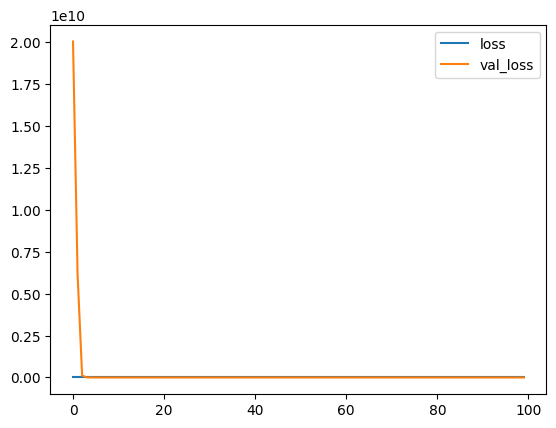

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Now let's add some e-constraints in the form of contrast in the image between the pedestrian and the background.

Epsilon Constraint: I've introduced an epsilon parameter in the function with a default small value (1e-6). This epsilon value is used to ensure that the computed widths and heights of the bounding boxes do not approach zero, which can lead to non-visible or inaccurately scaled bounding boxes on the images.
Width and Height Calculation: When computing width and height, the function now uses max(epsilon, bw * 448) and max(epsilon, bh * 448) to ensure that both dimensions are at least as large as epsilon, thus avoiding issues with very small or zero sizes that can result from floating point arithmetic or model prediction characteristics.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


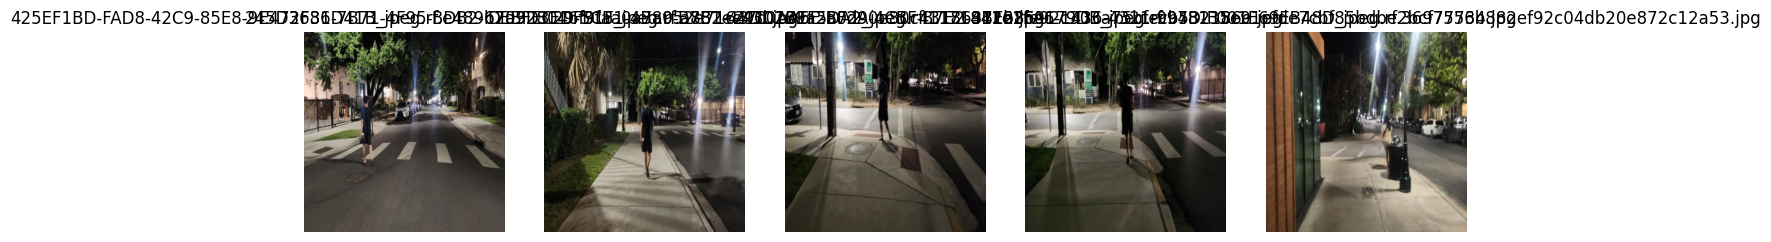

In [ ]:
def predict_and_display(model, images, file_names, num_display=5, conf_threshold=0.5, epsilon=1e-6):
    predictions = model.predict(images)

    # Select random images to display
    indices = random.sample(range(len(images)), num_display)

    plt.figure(figsize=(15, 10))
    for idx, i in enumerate(indices):
        img = images[i]
        pred = predictions[i]
        grid_size = 448 / 7

        # Iterate over each cell in the grid
        for cy in range(7):
            for cx in range(7):
                vector = pred[cy, cx]
                confidence = vector[4]

                # Apply confidence threshold to filter predictions
                if confidence > conf_threshold:
                    bx, by, bw, bh = vector[:4]

                    # Add epsilon to width and height to prevent them from being zero
                    width = max(epsilon, bw * 448)
                    height = max(epsilon, bh * 448)

                    # Convert predictions to pixel values for the actual image size
                    x_center = int((cx + bx) * grid_size)
                    y_center = int((cy + by) * grid_size)
                    x_min = int(x_center - width / 2)
                    y_min = int(y_center - height / 2)
                    x_max = int(x_center + width / 2)
                    y_max = int(y_center + height / 2)

                    # Draw bounding box on the image
                    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        # Display the image
        ax = plt.subplot(1, num_display, idx + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(file_names[i])

    plt.show()

# Load and preprocess the images
test_images, test_file_names = load_images_from_folder(test_image_dir)

# Make predictions and display the results
predict_and_display(model, test_images, test_file_names)


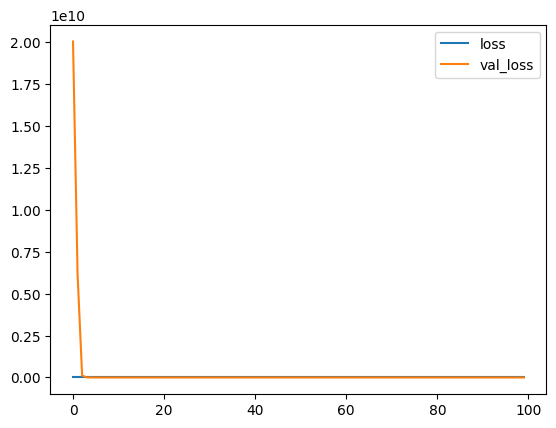

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Average Loss: 0.0


In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Compute and display the loss
compute_loss(model, test_image_dir, true_annotation_file, input_shape, num_classes)

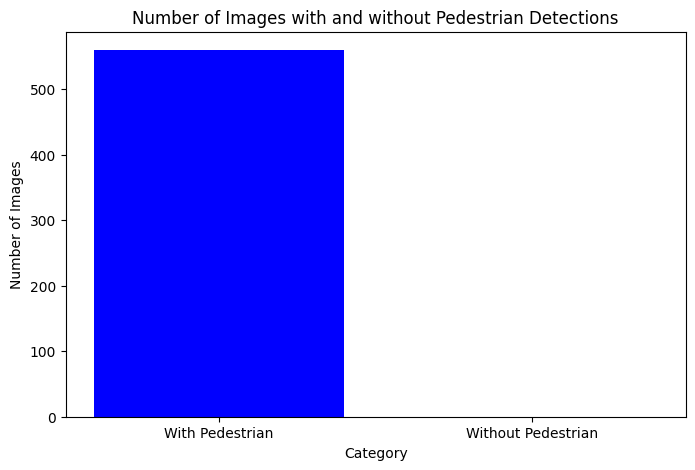

In [ ]:
import matplotlib.pyplot as plt

def plot_pedestrian_detections(y_data, num_classes):
    with_pedestrian = 0
    without_pedestrian = 0

    # Iterate through all annotations
    for y_sample in y_data:
        if np.sum(y_sample[..., num_classes + 4]) > 0:  # Check for any confidence value greater than 0
            with_pedestrian += 1
        else:
            without_pedestrian += 1

    # Bar graph plotting
    labels = ['With Pedestrian', 'Without Pedestrian']
    counts = [with_pedestrian, without_pedestrian]
    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color=['blue', 'red'])
    plt.title('Number of Images with and without Pedestrian Detections')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.show()

# Call this function after loading your dataset
plot_pedestrian_detections(y_train, num_classes)

# New loss function:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


IndexError: invalid index to scalar variable.

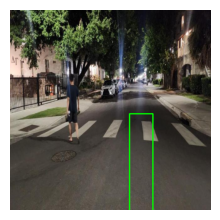

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def calculate_and_display_loss(model, test_image_dir, annotation_file, input_shape, num_classes, conf_threshold=0.5):
    # Load test images
    def load_images_from_folder(folder, target_size=(448, 448)):
        image_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
        images = []
        for img_name in image_files:
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img / 255.0)  # Normalize to 0-1
        return np.array(images)

    test_images = load_images_from_folder(test_image_dir)
    num_test_images = len(test_images)

    # Load true bounding boxes
    def load_true_bboxes(annotation_file, input_shape):
        with open(annotation_file, 'r') as f:
            lines = f.readlines()

        bboxes = np.zeros((num_test_images, 7, 7, num_classes + 5))
        for i, line in enumerate(lines):
            parts = line.strip().split()
            x_min = float(parts[1])
            y_min = float(parts[2])
            x_max = float(parts[3])
            y_max = float(parts[4])
            class_id = int(parts[5])

            box_center_x = (x_min + x_max) / 2 / input_shape[1]
            box_center_y = (y_min + y_max) / 2 / input_shape[0]
            box_width = (x_max - x_min) / input_shape[1]
            box_height = (y_max - y_min) / input_shape[0]

            cell_x = int(min(box_center_x * 7, 6))
            cell_y = int(min(box_center_y * 7, 6))

            bboxes[i, cell_y, cell_x, 0:4] = [box_center_x, box_center_y, box_width, box_height]
            bboxes[i, cell_y, cell_x, 4] = 1
            bboxes[i, cell_y, cell_x, 5 + class_id] = 1

        return bboxes

    true_bboxes = load_true_bboxes(annotation_file, input_shape)

    # Make predictions
    predictions = model.predict(test_images)

    # Calculate loss (Mean Squared Error)
    mse_loss = tf.keras.losses.MeanSquaredError()
    loss_values = mse_loss(true_bboxes, predictions).numpy()

    # Display results
    grid_size = 448 / 7
    plt.figure(figsize=(15, 10))
    for i in range(min(5, num_test_images)):
        img = test_images[i]
        pred = predictions[i]
        true = true_bboxes[i]

        for cy in range(7):
            for cx in range(7):
                if pred[cy, cx, 4] > conf_threshold:
                    bx, by, bw, bh = pred[cy, cx, :4]
                    x_center = int((cx + bx) * grid_size)
                    y_center = int((cy + by) * grid_size)
                    width = max(1, bw * 448)
                    height = max(1, bh * 448)
                    x_min = int(x_center - width / 2)
                    y_min = int(y_center - height / 2)
                    x_max = int(x_center + width / 2)
                    y_max = int(y_center + height / 2)
                    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        for cy in range(7):
            for cx in range(7):
                if true[cy, cx, 4] == 1:
                    bx, by, bw, bh = true[cy, cx, :4]
                    x_center = int((cx + bx) * grid_size)
                    y_center = int((cy + by) * grid_size)
                    width = max(1, bw * 448)
                    height = max(1, bh * 448)
                    x_min = int(x_center - width / 2)
                    y_min = int(y_center - height / 2)
                    x_max = int(x_center + width / 2)
                    y_max = int(y_center + height / 2)
                    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        ax = plt.subplot(1, 5, i + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Loss: {loss_values[i]:.4f}")

    plt.show()

    avg_loss = np.mean(loss_values)
    print(f"Average Loss: {avg_loss:.4f}")

# Define directories and file paths
test_image_dir = '/content/drive/MyDrive/My_pedestrian_dataset/testing_dataset_with_jack/test'
annotation_file = '/content/drive/MyDrive/My_pedestrian_dataset/testing_dataset_with_jack/modified_annotation.txt'

# Call the function
calculate_and_display_loss(model, test_image_dir, annotation_file, input_shape, num_classes)
